# **Tugas 3 MA4072 - Pembelajaran Mendalam**

oleh: \\
Michella Chandra - 10118011 \\
Thirafi Najwan Kurniatama - 13520157

*Notebook ini dijalankan menggunakan Google Colab, menjalankan notebook ini di _Local Machine_ mungkin akan mendapatkan hasil yang sedikit berbeda*

Akan dibuat 3 model CNN berbeda, yaitu 3 konfigurasi berbeda dari satu arsitektur yang sama dengan keterangan sebagai berikut:
1.   lapisan *dropout* dengan rasio **0.25** dan **0.5**, lapisan *Fully Connected* sebesar **64**, serta optimisasi **SGD**,
2.   lapisan *dropout* dengan rasio **0.5** dan **0.5**, lapisan *Fully Connected* sebesar **64** serta optimisasi **RMSprop**, dan
3.   lapisan *dropout* dengan rasio **0.5** dan **0.75**, lapisan *Fully Connected* sebesar **128** serta optimisasi **NADAM**.

Ketiga model ini akan diuji menggunakan data harga saham SPDR S&P 500 trust (SPY) yang didapatkan dari https://finance.yahoo.com/quote/SPY. Data berupa 7372 entri harga saham dari bulan Januari 1993 sampai Mei 2022, berupa nilai
saham ketika pasar dibuka (*Open*), harga tertinggi pada hari itu (*High*), harga terendah (*Low*), dan ketika pasar ditutup (*Close*). Terdapat juga harga saham ketika ditutup yang sudah disesuaikan dengan aksi perusahaan seperti deviden dan close split (*Adj. Close*) serta volume yaitu jumlah lembar saham yang diperdagangkan di hari tersebut.

# Dependencies

In [13]:
!pip install ta

In [14]:
!pip install imbalanced-learn

In [15]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import ta
from sklearn.model_selection import train_test_split
import random
import sklearn
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

# SEED

In [16]:
torch.manual_seed(13520157)
random.seed(13520157)
np.random.seed(13520157)

## GLOBAL VARIABLE

In [17]:
WINDOW_SIZE = 14 # LABELING WINDOW
INTERVAL_START = 3 # UNTUK IMAGE CREATION
INTERVAL_END = INTERVAL_START + 15 - 1 # 15 INTERVAL

## Function and Procedure

In [18]:
def dolabelling(dataframe):
  dataframe["Label"] = "HOLD" # HOLD by default
  dataframe["LabelEncode"] = 0
  windowSize = WINDOW_SIZE
  counterRow = 10
  while (counterRow < len(dataframe.index)):
    counterRow += 1
    if (counterRow >= windowSize): # START AT 0
      windowBeginIndex = counterRow - windowSize
      windowEndIndex = windowBeginIndex + windowSize - 1 if windowBeginIndex + windowSize - 1 < len(dataframe.index) else len(dataframe.index)
      windowMiddleIndex = (windowBeginIndex + windowEndIndex)//2
      maxIndex = 0 # Scope Extension
      minIndex = 0 # Scope Extension
      maxVal = 0.0 # Lets be real, no stock is going lower than 0
      minVal = np.finfo(dataframe["Close"].dtype).max
      for i in range(windowBeginIndex, windowEndIndex):
        number = dataframe.iloc[i, dataframe.columns.get_loc("Close")] # Essentially df[i]["Close"]
        if (number < minVal):
          minVal = number
          minIndex = i
        if (number > maxVal):
          maxVal = number
          maxIndex = i
      if (maxIndex == windowMiddleIndex):
        dataframe.iloc[maxIndex, dataframe.columns.get_loc("Label")] = "SELL"
        dataframe.iloc[maxIndex, dataframe.columns.get_loc("LabelEncode")] = 1
      elif (minIndex == windowMiddleIndex):
        dataframe.iloc[minIndex, dataframe.columns.get_loc("Label")] = "BUY"
        dataframe.iloc[minIndex, dataframe.columns.get_loc("LabelEncode")] = 2
  
def retnormed(dataframe):
  return (dataframe-dataframe.min())/(dataframe.max() - dataframe.min()) 

def print_eval(cf_matrix, classes):
    fpm = np.sum(cf_matrix, axis=0)
    fnm = np.sum(cf_matrix, axis=1)
    rec = [(cf_matrix[i][i]) / (fnm[i] + 1e-10) for i in range(len(cf_matrix))]
    prec = [(cf_matrix[i][i]) / (fpm[i] + 1e-10)for i in range(len(cf_matrix))]
    f1 = [2 * prec[i] * rec[i] / (prec[i] + rec[i] + 1e-10) for i in range(len(cf_matrix))]
    raw_m = np.vstack((rec, prec, f1))
    acc = np.trace(cf_matrix) / (np.sum(cf_matrix) + 1e-10)
    print(f"\nTotal Accuracy: {acc:.4f}")
    print(pd.DataFrame(raw_m, index = ["Recall", "Precision", "F1 Score"], columns=[i for i in classes]))

def do_financial_run(pred, date, closeprice, initial, stockname, model):
  plt.figure(figsize=(12, 6))
  plt.title(f"{model} Financial Run ({stockname})")
  plt.xlabel("Date")
  plt.ylabel("Net Worth (USD)")
  plt.figure(1).patch.set_facecolor("white")
  cdate = list(map(dt.datetime.strptime, date, len(date.index)*['%Y-%m-%d']))
  balance = initial
  curstock = 0
  networth = 10000
  xlogger, ylogger = np.array([]), np.array([])
  for i in range(len(pred)):
    if pred[i] == 1: # SELL
      balance += curstock * closeprice[i]
      curstock = 0
    elif pred[i] == 2:
      while (balance > closeprice[i]):
        balance -= closeprice[i]
        curstock += 1
    networth = balance + curstock * closeprice[i]
    xlogger = np.append(xlogger, cdate[i])
    ylogger = np.append(ylogger, networth)
  print(f"\nInitial Net Worth: ${initial}, At The End: ${networth:.2f}\n")
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.plot(xlogger, ylogger)
  plt.gcf().autofmt_xdate()
  plt.show()


In [19]:
# KOMPATIBEL DENGAN SELURUH CSV YANG DIUNDUH MELALUI YAHOO FINANCE
STOCKNAME = "SPY"
df = pd.read_csv('/content/SPY.csv')

In [20]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547981,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729704,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784195,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165777,531500


In [21]:
dolabelling(df)

In [22]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Label,LabelEncode
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.547981,1003200,HOLD,0
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.729704,480500,HOLD,0
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.784195,201300,HOLD,0
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.056751,529400,HOLD,0
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.165777,531500,HOLD,0
...,...,...,...,...,...,...,...,...,...
7367,2022-05-02,412.070007,415.920013,405.019989,414.480011,414.480011,158312500,HOLD,0
7368,2022-05-03,415.010010,418.929993,413.359985,416.380005,416.380005,100028200,HOLD,0
7369,2022-05-04,417.079987,429.660004,413.709991,429.059998,429.059998,144247900,HOLD,0
7370,2022-05-05,424.549988,425.000000,409.440002,413.809998,413.809998,172929100,HOLD,0


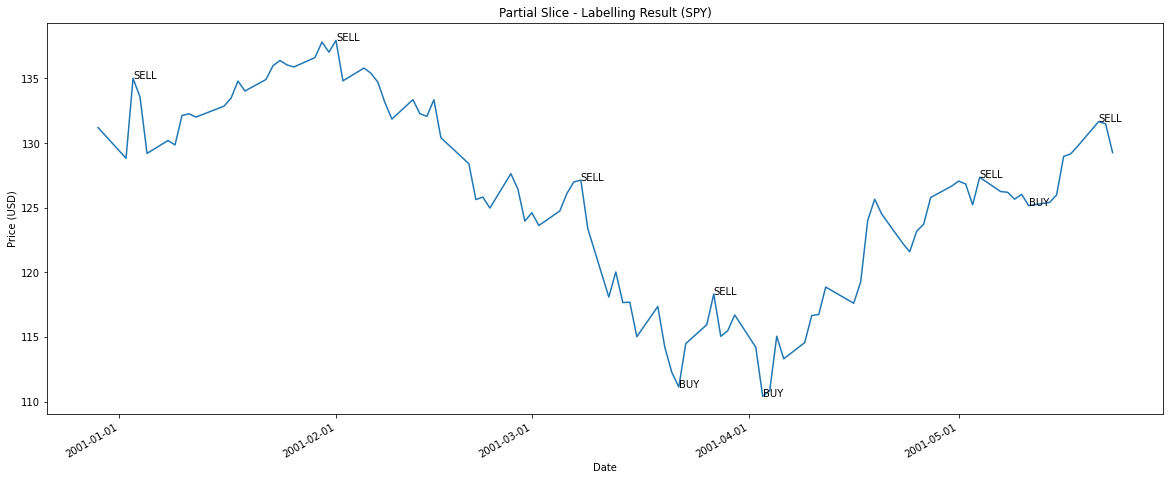

In [23]:
slices = df[2000:2100]
plt.figure(figsize=(20, 8))
plt.title("Partial Slice - Labelling Result (" + STOCKNAME + ")")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.figure(1).patch.set_facecolor("white")
cdate = list(map(dt.datetime.strptime, slices["Date"], len(slices["Date"].index)*['%Y-%m-%d']))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.plot(cdate, slices["Close"])
plt.gcf().autofmt_xdate()
for i in range(2000, 2100):
  if slices.loc[i]["Label"] != "HOLD":
    plt.annotate(slices.loc[i]["Label"], xy=(cdate[i-2000], slices.loc[i, "Close"]))
plt.show()

## Feature Generation

Momentum:
RSI
Williams %R
ROC
Stoch
PPO
PVO

Volume:
CMF

Volatility: 
ATR

Trend:
ADX
WMA
EMA
SMA
TRIX
CCI
MACD

### RSI

In [24]:
rsiTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.momentum.RSIIndicator(df["Close"], i, False).rsi()
  rsiTable = rsiTable.join(pd.DataFrame(temp).rename(columns = {'rsi':f'rsi_{i}'}))
rsiTable = rsiTable.drop(columns=["Close"])
rsiTable = rsiTable.dropna() # DROP INVALID
rsiTable = retnormed(rsiTable) # NORMALIZED

In [25]:
rsiTable # NORMALIZED, START VALID AT 21

,rsi_3,rsi_4,rsi_5,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_15,rsi_16,rsi_17
16,0.451025,0.386619,0.362193,0.352763,0.349359,0.348312,0.348037,0.347799,0.343436,0.338549,0.335497,0.332389,0.329253,0.328211,0.327212
17,0.816583,0.715459,0.652426,0.613896,0.590059,0.574910,0.565022,0.558386,0.547709,0.537827,0.530470,0.524039,0.518343,0.514759,0.511705
18,0.842931,0.746335,0.683505,0.644011,0.619122,0.603118,0.592618,0.585591,0.574414,0.564121,0.556385,0.549666,0.543752,0.539930,0.536686
19,0.862712,0.768802,0.705685,0.665206,0.639360,0.622596,0.611543,0.604142,0.592536,0.581891,0.573838,0.566871,0.560765,0.556744,0.553337
20,0.626371,0.623216,0.602332,0.584025,0.570929,0.562008,0.556002,0.551934,0.543095,0.534542,0.528177,0.522502,0.517396,0.514283,0.511609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.353388,0.338838,0.328280,0.320422,0.314810,0.310868,0.308073,0.305977,0.300883,0.295931,0.293384,0.291093,0.288976,0.289196,0.289515
7368,0.425905,0.391694,0.371539,0.357974,0.348557,0.341873,0.336995,0.333257,0.326549,0.320182,0.316344,0.312921,0.309806,0.309075,0.308542
7369,0.730059,0.646365,0.594293,0.559060,0.534098,0.515688,0.501622,0.490482,0.476032,0.462697,0.452331,0.443107,0.434800,0.429024,0.423918
7370,0.370953,0.382638,0.382047,0.377681,0.372575,0.367638,0.363084,0.358870,0.350976,0.343168,0.337753,0.332776,0.328173,0.325994,0.324122


### Will R

In [26]:
willR = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.momentum.WilliamsRIndicator(df["High"], df["Low"], df["Close"], i, False).williams_r()
  willR = willR.join(pd.DataFrame(temp).rename(columns = {'wr':f'wr_{i}'}))
willR = willR.drop(columns=["Close"])
willR = willR.dropna()
willR = retnormed(willR)

In [27]:
willR # VALID FROM ROW 21

,wr_3,wr_4,wr_5,wr_6,wr_7,wr_8,wr_9,wr_10,wr_11,wr_12,wr_13,wr_14,wr_15,wr_16,wr_17
16,0.647059,0.777778,0.777778,0.528302,0.424242,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378
17,1.000000,1.000000,1.000000,1.000000,0.867925,0.696970,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622
18,0.965517,0.965517,0.969697,0.980000,0.980000,0.924528,0.742424,0.662162,0.662162,0.662162,0.662162,0.662162,0.662162,0.662162,0.662162
19,0.956522,0.967742,0.967742,0.971429,0.980769,0.980769,0.962264,0.772727,0.689189,0.689189,0.689189,0.689189,0.689189,0.689189,0.689189
20,0.357143,0.666667,0.742857,0.742857,0.769231,0.839286,0.839286,0.839286,0.712121,0.635135,0.635135,0.635135,0.635135,0.635135,0.635135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.384241,0.384241,0.384241,0.384241,0.286147,0.210269,0.210269,0.210269,0.210269,0.210269,0.210269,0.210269,0.210269,0.207411,0.207139
7368,0.544845,0.461414,0.461414,0.461414,0.461414,0.343618,0.252501,0.252501,0.252501,0.252501,0.252501,0.252501,0.252501,0.252501,0.249068
7369,0.975649,0.975649,0.975649,0.975649,0.975649,0.975649,0.727163,0.534341,0.534341,0.534341,0.534341,0.534341,0.534341,0.534341,0.534341
7370,0.216122,0.356737,0.356737,0.356737,0.356737,0.356737,0.356737,0.265881,0.195377,0.195377,0.195377,0.195377,0.195377,0.195377,0.195377


### ROC

In [28]:
rocTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.momentum.roc(df["Close"], i, False)
  rocTable = rocTable.join(pd.DataFrame(temp).rename(columns = {'roc':f'roc_{i}'}))
rocTable = rocTable.drop(columns=["Close"])
rocTable = rocTable.dropna()
rocTable = retnormed(rocTable)

In [29]:
rocTable # START VALID AT 22

,roc_3,roc_4,roc_5,roc_6,roc_7,roc_8,roc_9,roc_10,roc_11,roc_12,roc_13,roc_14,roc_15,roc_16,roc_17
17,0.489984,0.552746,0.552693,0.570414,0.559006,0.558795,0.581148,0.544569,0.530903,0.507640,0.505824,0.508817,0.508811,0.533162,0.546802
18,0.485119,0.548534,0.560074,0.577386,0.626737,0.583226,0.574508,0.546068,0.549883,0.511828,0.510996,0.504810,0.493903,0.533162,0.537554
19,0.492178,0.542351,0.554386,0.582632,0.632023,0.651715,0.596412,0.538831,0.549903,0.528502,0.513593,0.508903,0.489020,0.515947,0.536241
20,0.440628,0.536375,0.537797,0.566860,0.626808,0.646315,0.652086,0.548970,0.533817,0.520095,0.521275,0.503419,0.485280,0.502831,0.511678
21,0.482152,0.541823,0.577968,0.594304,0.654558,0.686271,0.690604,0.634884,0.580947,0.539748,0.546105,0.546006,0.511346,0.531842,0.531059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.416425,0.487426,0.421442,0.461613,0.446794,0.426023,0.439665,0.450779,0.452196,0.409104,0.435461,0.419494,0.380533,0.388065,0.400757
7368,0.350845,0.492354,0.506689,0.458782,0.522594,0.472616,0.451734,0.428109,0.460538,0.441505,0.423460,0.434959,0.417011,0.400829,0.399979
7369,0.573881,0.506506,0.577057,0.602190,0.580884,0.615222,0.556679,0.489617,0.488818,0.498880,0.499706,0.470165,0.474972,0.486284,0.457048
7370,0.433023,0.510625,0.421484,0.507061,0.564371,0.510892,0.536835,0.447149,0.417895,0.398779,0.433893,0.425519,0.393729,0.427099,0.423725


### STOCH

In [30]:
stochTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.momentum.stoch(df["High"], df["Low"], df["Close"], i, 3, False)
  stochTable = stochTable.join(pd.DataFrame(temp).rename(columns = {'stoch_k':f'stoch_k_{i}'}))
stochTable = stochTable.drop(columns=["Close"])
stochTable = stochTable.dropna()
stochTable = retnormed(stochTable)

In [31]:
stochTable # START AT 21

,stoch_k_3,stoch_k_4,stoch_k_5,stoch_k_6,stoch_k_7,stoch_k_8,stoch_k_9,stoch_k_10,stoch_k_11,stoch_k_12,stoch_k_13,stoch_k_14,stoch_k_15,stoch_k_16,stoch_k_17
16,0.647059,0.777778,0.777778,0.528302,0.424242,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378,0.378378
17,1.000000,1.000000,1.000000,1.000000,0.867925,0.696970,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622,0.621622
18,0.965517,0.965517,0.969697,0.980000,0.980000,0.924528,0.742424,0.662162,0.662162,0.662162,0.662162,0.662162,0.662162,0.662162,0.662162
19,0.956522,0.967742,0.967742,0.971429,0.980769,0.980769,0.962264,0.772727,0.689189,0.689189,0.689189,0.689189,0.689189,0.689189,0.689189
20,0.357143,0.666667,0.742857,0.742857,0.769231,0.839286,0.839286,0.839286,0.712121,0.635135,0.635135,0.635135,0.635135,0.635135,0.635135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.384241,0.384241,0.384241,0.384241,0.286147,0.210269,0.210269,0.210269,0.210269,0.210269,0.210269,0.210269,0.210269,0.207411,0.207139
7368,0.544845,0.461414,0.461414,0.461414,0.461414,0.343618,0.252501,0.252501,0.252501,0.252501,0.252501,0.252501,0.252501,0.252501,0.249068
7369,0.975649,0.975649,0.975649,0.975649,0.975649,0.975649,0.727163,0.534341,0.534341,0.534341,0.534341,0.534341,0.534341,0.534341,0.534341
7370,0.216122,0.356737,0.356737,0.356737,0.356737,0.356737,0.356737,0.265881,0.195377,0.195377,0.195377,0.195377,0.195377,0.195377,0.195377


### PPO

In [32]:
ppoTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.momentum.PercentagePriceOscillator(df["Close"], window_sign=i, fillna=False).ppo()
  ppoTable = ppoTable.join(pd.DataFrame(temp).rename(columns = {'PPO_12_26':f'PPO_12_26_{i}'}))
ppoTable = ppoTable.drop(columns=["Close"])
ppoTable = ppoTable.dropna()
ppoTable = retnormed(ppoTable)

In [33]:
ppoTable # VALID START AT 25

,PPO_12_26_3,PPO_12_26_4,PPO_12_26_5,PPO_12_26_6,PPO_12_26_7,PPO_12_26_8,PPO_12_26_9,PPO_12_26_10,PPO_12_26_11,PPO_12_26_12,PPO_12_26_13,PPO_12_26_14,PPO_12_26_15,PPO_12_26_16,PPO_12_26_17
25,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103,0.786103
26,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188,0.796188
27,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806,0.804806
28,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839,0.808839
29,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010,0.804010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917,0.594917
7368,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983,0.588983
7369,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433,0.606433
7370,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966,0.596966


### PVO

In [34]:
pvoTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.momentum.PercentageVolumeOscillator(df["Volume"], window_sign=i, fillna=False).pvo()
  pvoTable = pvoTable.join(pd.DataFrame(temp).rename(columns = {'PVO_12_26':f'PVO_12_26_{i}'}))
pvoTable = pvoTable.drop(columns=["Close"])
pvoTable = pvoTable.dropna()
pvoTable = retnormed(pvoTable)

In [35]:
pvoTable # VALID START AT 25

,PVO_12_26_3,PVO_12_26_4,PVO_12_26_5,PVO_12_26_6,PVO_12_26_7,PVO_12_26_8,PVO_12_26_9,PVO_12_26_10,PVO_12_26_11,PVO_12_26_12,PVO_12_26_13,PVO_12_26_14,PVO_12_26_15,PVO_12_26_16,PVO_12_26_17
25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751,0.022751
27,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517,0.053517
28,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032,0.037032
29,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322,0.221322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143,0.539143
7368,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357,0.522357
7369,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173,0.536173
7370,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699,0.561699


### CMF

In [36]:
cmfTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.volume.ChaikinMoneyFlowIndicator(df["High"], df["Low"], df["Close"], df["Volume"], window=i, fillna=False).chaikin_money_flow()
  cmfTable = cmfTable.join(pd.DataFrame(temp).rename(columns = {'cmf':f'cmf_{i}'}))
cmfTable = cmfTable.drop(columns=["Close"])
cmfTable = cmfTable.dropna()
cmfTable = retnormed(cmfTable)

In [37]:
cmfTable # VALID START AT 21

,cmf_3,cmf_4,cmf_5,cmf_6,cmf_7,cmf_8,cmf_9,cmf_10,cmf_11,cmf_12,cmf_13,cmf_14,cmf_15,cmf_16,cmf_17
16,0.647067,0.614201,0.618614,0.504624,0.484957,0.466690,0.557039,0.532561,0.473426,0.495087,0.544054,0.627764,0.648235,0.696727,0.773820
17,0.643745,0.664839,0.626017,0.648719,0.507976,0.476503,0.484415,0.551779,0.556323,0.450204,0.479265,0.561398,0.633173,0.641233,0.716665
18,0.591613,0.662175,0.680861,0.658623,0.659220,0.502935,0.496592,0.484122,0.578583,0.541627,0.435483,0.498319,0.568357,0.626775,0.656848
19,0.897017,0.633892,0.683043,0.723084,0.674867,0.665911,0.528065,0.500978,0.514120,0.569714,0.535748,0.459862,0.509946,0.565166,0.643487
20,0.607315,0.666140,0.578366,0.673174,0.689929,0.641363,0.653338,0.500678,0.499240,0.470210,0.534210,0.532050,0.449433,0.487144,0.557336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.565419,0.494197,0.398378,0.512107,0.417952,0.351762,0.348290,0.385931,0.401844,0.313549,0.325652,0.309884,0.277530,0.258691,0.261409
7368,0.484371,0.559875,0.498759,0.423572,0.511470,0.409605,0.374917,0.354318,0.403575,0.378225,0.299216,0.347669,0.323556,0.278050,0.248087
7369,0.817312,0.614592,0.660155,0.614260,0.524085,0.583231,0.507038,0.452214,0.448333,0.455565,0.437344,0.395412,0.427674,0.388157,0.338153
7370,0.570900,0.659503,0.525756,0.589562,0.540263,0.453830,0.532300,0.451756,0.424214,0.378788,0.390249,0.407487,0.362755,0.379552,0.340227


### ATR

In [38]:
atrTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.volatility.AverageTrueRange(df["High"], df["Low"], df["Close"], window=i, fillna=False).average_true_range()
  atrTable = atrTable.join(pd.DataFrame(temp).rename(columns = {'atr':f'atr_{i}'}))
atrTable = atrTable.drop(columns=["Close"])
atrTable = atrTable.dropna()
atrTable = retnormed(atrTable)

In [39]:
atrTable # PRACTICALLY VALID AT 21

,atr_3,atr_4,atr_5,atr_6,atr_7,atr_8,atr_9,atr_10,atr_11,atr_12,atr_13,atr_14,atr_15,atr_16,atr_17
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.010542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.013775,0.014041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.017617,0.017380,0.017619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.487361,0.507766,0.514885,0.519952,0.527231,0.536412,0.547206,0.559350,0.572606,0.584409,0.591139,0.599008,0.607943,0.617706,0.628108
7368,0.400069,0.441867,0.463391,0.478199,0.492201,0.506229,0.520635,0.535542,0.550960,0.564568,0.572941,0.582150,0.592191,0.602881,0.614069
7369,0.481941,0.506198,0.518136,0.527089,0.537258,0.548527,0.560805,0.573985,0.587951,0.600161,0.606970,0.614815,0.623663,0.633299,0.643550
7370,0.586046,0.594667,0.595852,0.597418,0.602423,0.609830,0.619065,0.629753,0.641615,0.651803,0.656351,0.662231,0.669362,0.677485,0.686390


### ADX

In [40]:
adxTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.ADXIndicator(df["High"], df["Low"], df["Close"], window=i, fillna=False).adx()
  adxTable = adxTable.join(pd.DataFrame(temp).rename(columns = {'adx':f'adx_{i}'}))
adxTable = adxTable.drop(columns=["Close"])
adxTable = adxTable.dropna()
adxTable = retnormed(adxTable)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [41]:
adxTable # PRACTICALLY START AT 43

,adx_3,adx_4,adx_5,adx_6,adx_7,adx_8,adx_9,adx_10,adx_11,adx_12,adx_13,adx_14,adx_15,adx_16,adx_17
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.519306,0.529379,0.522653,0.508856,0.493761,0.478799,0.465118,0.453317,0.436702,0.423206,0.412667,0.404801,0.400588,0.399537,0.401297
7368,0.438403,0.483537,0.496692,0.495696,0.489107,0.480042,0.470521,0.461658,0.446934,0.434606,0.424760,0.417165,0.412977,0.411801,0.413342
7369,0.425647,0.422110,0.423375,0.422019,0.419830,0.426302,0.428044,0.427589,0.419718,0.412609,0.406801,0.402344,0.400577,0.401294,0.404327
7370,0.304959,0.317865,0.348849,0.368076,0.379684,0.394737,0.403231,0.408092,0.404663,0.400988,0.397857,0.395461,0.395266,0.397193,0.401164


### WMA

In [42]:
wmaTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.WMAIndicator(df["Close"], window=i, fillna=False).wma()
  wmaTable = wmaTable.join(pd.DataFrame(temp).rename(columns = {'wma':f'wma_{i}'}))
wmaTable = wmaTable.drop(columns=["Close"])
wmaTable = wmaTable.dropna()
wmaTable = retnormed(wmaTable)

In [43]:
wmaTable # START VALID AT 21

,wma_3,wma_4,wma_5,wma_6,wma_7,wma_8,wma_9,wma_10,wma_11,wma_12,wma_13,wma_14,wma_15,wma_16,wma_17
16,0.000156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000010,0.000009,0.000003
17,0.000841,0.000606,0.000529,0.000464,0.000319,0.000204,0.000140,0.000097,0.000056,0.000026,0.000003,0.000000,0.000000,0.000000,0.000000
18,0.001369,0.001103,0.001005,0.000903,0.000721,0.000501,0.000347,0.000251,0.000173,0.000107,0.000057,0.000032,0.000019,0.000017,0.000016
19,0.001730,0.001478,0.001385,0.001285,0.001087,0.000846,0.000613,0.000447,0.000326,0.000229,0.000147,0.000098,0.000065,0.000050,0.000047
20,0.001670,0.001579,0.001539,0.001473,0.001301,0.001067,0.000831,0.000613,0.000441,0.000313,0.000210,0.000137,0.000086,0.000057,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.858486,0.860927,0.861702,0.863344,0.864875,0.867372,0.870628,0.874283,0.877994,0.881469,0.884682,0.887447,0.890009,0.892462,0.894753
7368,0.856506,0.859533,0.860816,0.861378,0.862604,0.864213,0.866644,0.869814,0.873506,0.877028,0.880182,0.883058,0.885707,0.888127,0.890403
7369,0.873541,0.870050,0.869642,0.869107,0.868447,0.868954,0.869977,0.871885,0.874674,0.877753,0.880581,0.883088,0.885555,0.887806,0.889835
7370,0.866434,0.866200,0.864921,0.865354,0.865443,0.865674,0.866723,0.868199,0.870513,0.873296,0.876139,0.878702,0.881140,0.883488,0.885595


### EMA

In [44]:
emaTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.EMAIndicator(df["Close"], window=i, fillna=False).ema_indicator()
  emaTable = emaTable.join(pd.DataFrame(temp).rename(columns = {'ema':f'ema_{i}'}))
emaTable = emaTable.drop(columns=["Close"])
emaTable = emaTable.dropna()
emaTable = retnormed(emaTable)

In [45]:
emaTable # START VALID AT 21

,ema_3,ema_4,ema_5,ema_6,ema_7,ema_8,ema_9,ema_10,ema_11,ema_12,ema_13,ema_14,ema_15,ema_16,ema_17
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.000673,0.000525,0.000413,0.000328,0.000263,0.000214,0.000176,0.000147,0.000125,0.000107,0.000092,0.000081,0.000072,0.000064,0.000058
18,0.001117,0.000926,0.000761,0.000624,0.000515,0.000429,0.000361,0.000307,0.000265,0.000231,0.000203,0.000180,0.000162,0.000146,0.000134
19,0.001411,0.001225,0.001040,0.000877,0.000740,0.000628,0.000538,0.000465,0.000406,0.000358,0.000318,0.000286,0.000259,0.000236,0.000217
20,0.001414,0.001289,0.001131,0.000975,0.000837,0.000719,0.000621,0.000541,0.000475,0.000421,0.000376,0.000338,0.000307,0.000281,0.000259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.859674,0.863222,0.866992,0.870848,0.874667,0.878367,0.881899,0.885235,0.888365,0.891285,0.894001,0.896523,0.898863,0.901036,0.903057
7368,0.859805,0.862165,0.865122,0.868403,0.871811,0.875220,0.878547,0.881746,0.884787,0.887658,0.890355,0.892881,0.895242,0.897449,0.899513
7369,0.874499,0.873243,0.873644,0.875039,0.877014,0.879308,0.881756,0.884251,0.886725,0.889135,0.891455,0.893670,0.895775,0.897771,0.899659
7370,0.864253,0.865804,0.867576,0.869697,0.872083,0.874627,0.877240,0.879854,0.882424,0.884918,0.887316,0.889608,0.891789,0.893860,0.895824


### SMA

In [46]:
smaTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.SMAIndicator(df["Close"], window=i, fillna=False).sma_indicator()
  smaTable = smaTable.join(pd.DataFrame(temp).rename(columns = {'sma':f'sma_{i}'}))
smaTable = smaTable.drop(columns=["Close"])
smaTable = smaTable.dropna()
smaTable = retnormed(smaTable)

In [47]:
smaTable # START VALID AT 21

,sma_3,sma_4,sma_5,sma_6,sma_7,sma_8,sma_9,sma_10,sma_11,sma_12,sma_13,sma_14,sma_15,sma_16,sma_17
16,0.000000,0.000000,0.000000,0.000000,0.000113,0.000271,0.000322,0.000377,0.000423,0.000394,0.000415,0.000411,0.000297,0.000288,0.000262
17,0.000529,0.000487,0.000375,0.000301,0.000000,0.000072,0.000201,0.000283,0.000271,0.000255,0.000280,0.000318,0.000282,0.000288,0.000305
18,0.001009,0.000937,0.000808,0.000649,0.000289,0.000000,0.000048,0.000196,0.000205,0.000133,0.000168,0.000208,0.000209,0.000288,0.000318
19,0.001562,0.001334,0.001197,0.001034,0.000608,0.000271,0.000000,0.000073,0.000139,0.000085,0.000067,0.000115,0.000117,0.000228,0.000327
20,0.001586,0.001677,0.001457,0.001310,0.000897,0.000515,0.000209,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000123,0.000254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.863667,0.863730,0.863253,0.867449,0.869485,0.876162,0.883588,0.889723,0.893305,0.896534,0.899964,0.901680,0.903829,0.907258,0.910434
7368,0.854879,0.863216,0.863383,0.862782,0.866300,0.869894,0.876292,0.883068,0.888740,0.892378,0.895132,0.898028,0.900163,0.902700,0.905974
7369,0.867996,0.863938,0.868826,0.867768,0.866481,0.870767,0.873974,0.879434,0.885361,0.890648,0.893566,0.895653,0.898726,0.901113,0.903426
7370,0.867481,0.864982,0.862362,0.866437,0.865726,0.866517,0.870824,0.873803,0.878827,0.884584,0.889231,0.891657,0.894133,0.897535,0.899831


### TRIX

In [48]:
trixTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.TRIXIndicator(df["Close"], window=i, fillna=False).trix()
  trixTable = trixTable.join(pd.DataFrame(temp).rename(columns = {'trix':f'trix_{i}'}))
trixTable = trixTable.drop(columns=["Close"])
trixTable = trixTable.dropna()
trixTable = retnormed(trixTable)

In [49]:
trixTable # STARTING AT 64

,trix_3,trix_4,trix_5,trix_6,trix_7,trix_8,trix_9,trix_10,trix_11,trix_12,trix_13,trix_14,trix_15,trix_16,trix_17
49,0.693248,0.669875,0.645458,0.634754,0.649754,0.666942,0.695803,0.704912,0.707342,0.710240,0.711268,0.709587,0.704955,0.703670,0.704038
50,0.722951,0.697965,0.668013,0.652037,0.661591,0.674846,0.700783,0.707516,0.708141,0.709680,0.709713,0.707377,0.702410,0.701055,0.701552
51,0.727868,0.713343,0.684889,0.667445,0.673618,0.683931,0.707430,0.711946,0.710767,0.710864,0.709787,0.706651,0.701186,0.699584,0.700036
52,0.721835,0.719038,0.695533,0.679357,0.684156,0.692702,0.714458,0.717151,0.714366,0.713101,0.710926,0.706950,0.700910,0.698958,0.699252
53,0.712839,0.718762,0.701005,0.687595,0.692560,0.700393,0.721111,0.722453,0.718354,0.715897,0.712714,0.707927,0.701295,0.698943,0.699009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.571217,0.548331,0.517663,0.498424,0.516336,0.535640,0.565941,0.581284,0.591220,0.601934,0.610129,0.615763,0.618691,0.625454,0.633680
7368,0.600891,0.567308,0.528282,0.502190,0.514482,0.529518,0.556293,0.569039,0.577059,0.586426,0.593661,0.598764,0.601538,0.608590,0.617409
7369,0.700405,0.635340,0.576482,0.536531,0.536392,0.542664,0.562872,0.570324,0.574283,0.580579,0.585491,0.588918,0.590560,0.597018,0.605656
7370,0.671911,0.640640,0.590382,0.550706,0.546906,0.549117,0.565429,0.569279,0.570196,0.574027,0.576963,0.578899,0.579490,0.585371,0.593807


### CCI

In [50]:
cciTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.CCIIndicator(df["High"], df["Low"], df["Close"], window=i, fillna=False).cci()
  cciTable = cciTable.join(pd.DataFrame(temp).rename(columns = {'cci':f'cci_{i}'}))
cciTable = cciTable.drop(columns=["Close"])
cciTable = cciTable.dropna()
cciTable = retnormed(cciTable)

In [51]:
cciTable # START AT 21

,cci_3,cci_4,cci_5,cci_6,cci_7,cci_8,cci_9,cci_10,cci_11,cci_12,cci_13,cci_14,cci_15,cci_16,cci_17
16,0.729730,0.739362,0.741379,0.621951,0.472593,0.446353,0.452100,0.432044,0.443310,0.434659,0.434701,0.424387,0.409317,0.427046,0.434411
17,1.000000,1.000000,0.956019,0.893939,0.834107,0.624969,0.558955,0.526189,0.528353,0.509954,0.507746,0.495755,0.480154,0.497649,0.502601
18,0.906250,0.855263,0.827640,0.813291,0.806452,0.792371,0.665429,0.591096,0.583484,0.564140,0.554881,0.538739,0.519630,0.533743,0.539454
19,0.847826,0.785714,0.750789,0.726930,0.714839,0.711769,0.730806,0.645209,0.609921,0.586622,0.582064,0.560216,0.537950,0.548790,0.550272
20,0.807692,0.739726,0.692308,0.683857,0.666218,0.660058,0.673326,0.677015,0.641129,0.599101,0.593006,0.576117,0.549331,0.557668,0.556295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.093827,0.100711,0.111652,0.173180,0.241616,0.292454,0.329669,0.324437,0.344197,0.341323,0.344159,0.336215,0.323116,0.341881,0.340059
7368,0.738573,0.426397,0.419339,0.410743,0.395292,0.396015,0.408879,0.389529,0.409270,0.404546,0.406661,0.398183,0.384180,0.400491,0.400311
7369,1.000000,1.000000,0.731402,0.731565,0.719192,0.647282,0.597637,0.528314,0.512622,0.494274,0.493974,0.482107,0.464933,0.478849,0.478395
7370,0.243430,0.430724,0.441828,0.413246,0.413026,0.413286,0.421732,0.404010,0.420108,0.413747,0.418571,0.412698,0.400974,0.418534,0.418452


### MACD

In [52]:
macdTable = df[["Close"]]
for i in range(INTERVAL_START, INTERVAL_END+1):
  temp = ta.trend.MACD(df["Close"], window_sign=i, fillna=False).macd()
  macdTable = macdTable.join(pd.DataFrame(temp).rename(columns = {'MACD_12_26':f'MACD_12_26_{i}'}))
macdTable = macdTable.drop(columns=["Close"])
macdTable = macdTable.dropna()
macdTable = retnormed(macdTable)

In [53]:
macdTable # START AT 25

,MACD_12_26_3,MACD_12_26_4,MACD_12_26_5,MACD_12_26_6,MACD_12_26_7,MACD_12_26_8,MACD_12_26_9,MACD_12_26_10,MACD_12_26_11,MACD_12_26_12,MACD_12_26_13,MACD_12_26_14,MACD_12_26_15,MACD_12_26_16,MACD_12_26_17
25,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635,0.728635
26,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230,0.730230
27,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601,0.731601
28,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251,0.732251
29,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499,0.731499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968,0.503968
7368,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582,0.495582
7369,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239,0.522239
7370,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516,0.508516


## Merging

In [54]:
MSV = 49 # MOST STARING VALID: TRIX TABLE

In [55]:
imgdat = df[["Date", "Close", "Label", "LabelEncode"]].loc[MSV:]
# Momentum:
imgdat = imgdat.join(rsiTable.loc[MSV:]) # RSI
imgdat = imgdat.join(willR.loc[MSV:]) # Williams %R
imgdat = imgdat.join(rocTable.loc[MSV:]) # ROC
imgdat = imgdat.join(stochTable.loc[MSV:]) # Stoch
imgdat = imgdat.join(ppoTable.loc[MSV:]) # PPO
imgdat = imgdat.join(pvoTable.loc[MSV:]) # PVO

# Volume:
imgdat = imgdat.join(cmfTable.loc[MSV:]) # CMF

# Volatility: 
imgdat = imgdat.join(atrTable.loc[MSV:]) # ATR

# Trend:
imgdat = imgdat.join(adxTable.loc[MSV:]) # ADX
imgdat = imgdat.join(wmaTable.loc[MSV:]) # WMA
imgdat = imgdat.join(emaTable.loc[MSV:]) # EMA
imgdat = imgdat.join(smaTable.loc[MSV:]) # SMA
imgdat = imgdat.join(trixTable.loc[MSV:]) # TRIX
imgdat = imgdat.join(cciTable.loc[MSV:]) # CCI
imgdat = imgdat.join(macdTable.loc[MSV:]) # MACD


# SANITY CHECK
imgdat.reset_index(drop=True, inplace=True) # RESET INDEX
imgdat[(imgdat.iloc[:, 4:] >= 0).all(1)] # DELETE ANY BELOW ZERO VALUE
imgdat.iloc[:, 4:] *= 255 # APPROPCHANNEL

In [56]:
imgdat

,Date,Close,Label,LabelEncode,rsi_3,rsi_4,rsi_5,rsi_6,rsi_7,rsi_8,...,MACD_12_26_8,MACD_12_26_9,MACD_12_26_10,MACD_12_26_11,MACD_12_26_12,MACD_12_26_13,MACD_12_26_14,MACD_12_26_15,MACD_12_26_16,MACD_12_26_17
0,1993-04-12,44.906250,HOLD,0,196.444138,175.034311,161.687246,153.009466,147.261130,143.386917,...,183.193014,183.193014,183.193014,183.193014,183.193014,183.193014,183.193014,183.193014,183.193014,183.193014
1,1993-04-13,45.000000,SELL,1,203.874190,182.755940,169.151916,160.092581,153.963945,149.746114,...,183.453880,183.453880,183.453880,183.453880,183.453880,183.453880,183.453880,183.453880,183.453880,183.453880
2,1993-04-14,44.937500,HOLD,0,180.898868,168.382316,158.709575,151.806606,146.999897,143.656040,...,183.624241,183.624241,183.624241,183.624241,183.624241,183.624241,183.624241,183.624241,183.624241,183.624241
3,1993-04-15,44.937500,HOLD,0,180.898868,168.382316,158.709575,151.806606,146.999897,143.656040,...,183.760288,183.760288,183.760288,183.760288,183.760288,183.760288,183.760288,183.760288,183.760288,183.760288
4,1993-04-16,44.937500,HOLD,0,180.898868,168.382316,158.709575,151.806606,146.999897,143.656040,...,183.867899,183.867899,183.867899,183.867899,183.867899,183.867899,183.867899,183.867899,183.867899,183.867899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7318,2022-05-02,414.480011,HOLD,0,90.113982,86.403802,83.711473,81.707723,80.276607,79.271282,...,128.511887,128.511887,128.511887,128.511887,128.511887,128.511887,128.511887,128.511887,128.511887,128.511887
7319,2022-05-03,416.380005,HOLD,0,108.605672,99.881948,94.742361,91.283297,88.882035,87.177662,...,126.373360,126.373360,126.373360,126.373360,126.373360,126.373360,126.373360,126.373360,126.373360,126.373360
7320,2022-05-04,429.059998,HOLD,0,186.164983,164.822974,151.544725,142.560349,136.195025,131.500341,...,133.170929,133.170929,133.170929,133.170929,133.170929,133.170929,133.170929,133.170929,133.170929,133.170929
7321,2022-05-05,413.809998,HOLD,0,94.593044,97.572679,97.422021,96.308597,95.006734,93.747600,...,129.671571,129.671571,129.671571,129.671571,129.671571,129.671571,129.671571,129.671571,129.671571,129.671571


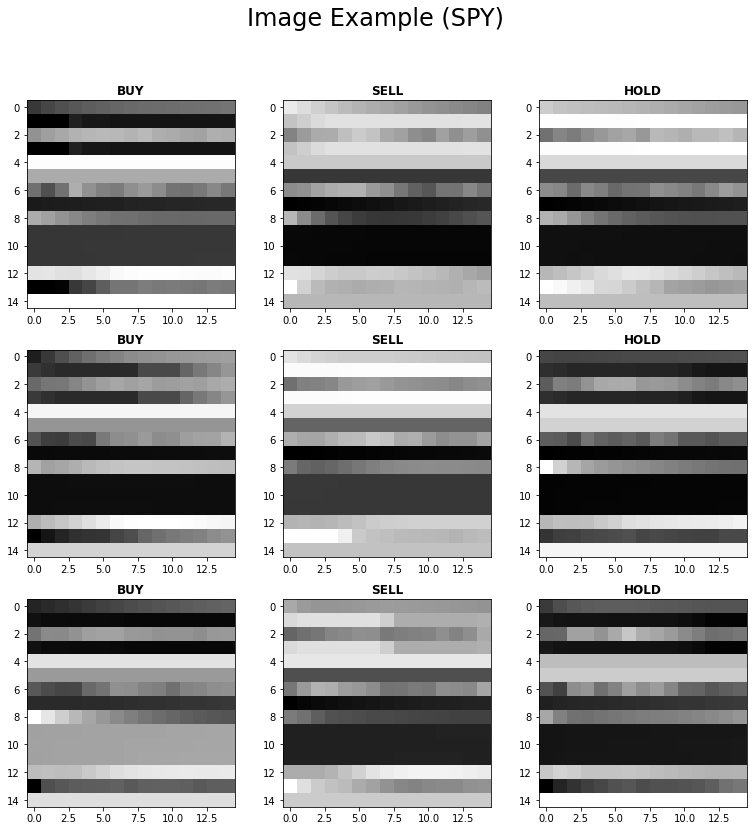

In [57]:
buyimg = imgdat[imgdat["Label"] == "BUY"]
sellimg = imgdat[imgdat["Label"] == "SELL"]
holdimg = imgdat[imgdat["Label"] == "HOLD"]
fig, ax = plt.subplots(3,3, figsize=(13, 13))
fig.set_facecolor("white")
fig.suptitle(f"Image Example ({STOCKNAME})", fontsize=24)
for i in range(3):
  pickindex = random.randint(0, len(buyimg.index))
  ax[i, 0].set_title("BUY", fontweight='bold')
  ax[i, 0].imshow(np.array(buyimg.iloc[pickindex, 4:].values.reshape((15, 15)), dtype='float64'), cmap='gray')
  pickindex = random.randint(0, len(sellimg.index))
  ax[i, 1].set_title("SELL", fontweight='bold')
  ax[i, 1].imshow(np.array(sellimg.iloc[pickindex, 4:].values.reshape((15, 15)), dtype='float64'), cmap='gray')
  pickindex = random.randint(0, len(holdimg.index))
  ax[i, 2].set_title("HOLD", fontweight='bold')
  ax[i, 2].imshow(np.array(holdimg.iloc[pickindex, 4:].values.reshape((15, 15)), dtype='float64'), cmap='gray')
fig.show()

# Training

## Preprocess

### Split Dataset

In [58]:
# traindat_le, testdat_le = train_test_split(imgdat_le, test_size=0.2, shuffle=False)
# traindat_le.reset_index(drop=True, inplace=True)
# testdat_le.reset_index(drop=True, inplace=True)
# inp_train_le, out_train_le = traindat_le.iloc[:, 3:], traindat_le.iloc[:, 2]
# inp_test_le, out_test_le = testdat_le.iloc[:, 3:], testdat_le.iloc[:, 2]
# inp_train_le_tensor = torch.tensor(inp_train_le.values).reshape(len(inp_train_le), 1, 15, 15).float()
# out_train_le_tensor = torch.tensor(out_train_le.values).type(torch.LongTensor)
# inp_test_le_tensor = torch.tensor(inp_test_le.values).reshape(len(inp_test_le), 1, 15, 15).float()
# out_test_le_tensor = torch.tensor(out_test_le.values).type(torch.LongTensor)
scaler = sklearn.preprocessing.StandardScaler()
train_data, test_data = train_test_split(imgdat, test_size=0.2, shuffle=False)
train_data.reset_index(drop=True, inplace=True)
in_train, out_train = torch.tensor(scaler.fit_transform(train_data.iloc[:, 4:])).reshape(len(train_data), 1, 15, 15).float(), torch.tensor(train_data["LabelEncode"].values).type(torch.LongTensor)
test_data.reset_index(drop=True, inplace=True)
in_test, out_test = torch.tensor(scaler.transform(test_data.iloc[:, 4:])).reshape(len(test_data), 1, 15, 15).float(), torch.tensor(test_data["LabelEncode"].values).type(torch.LongTensor)

#### SMOTE

In [59]:
# oversampler = SMOTE()
# oversampled_train_inp, oversampled_train_out = oversampler.fit_resample(inp_train_le, out_train_le)
# oversampled_train_inp_tensor = torch.tensor(oversampled_train_inp.values).reshape(len(oversampled_train_inp), 1, 15, 15).float()
# oversampled_train_out_tensor = torch.tensor(oversampled_train_out.values).type(torch.LongTensor)

### Details

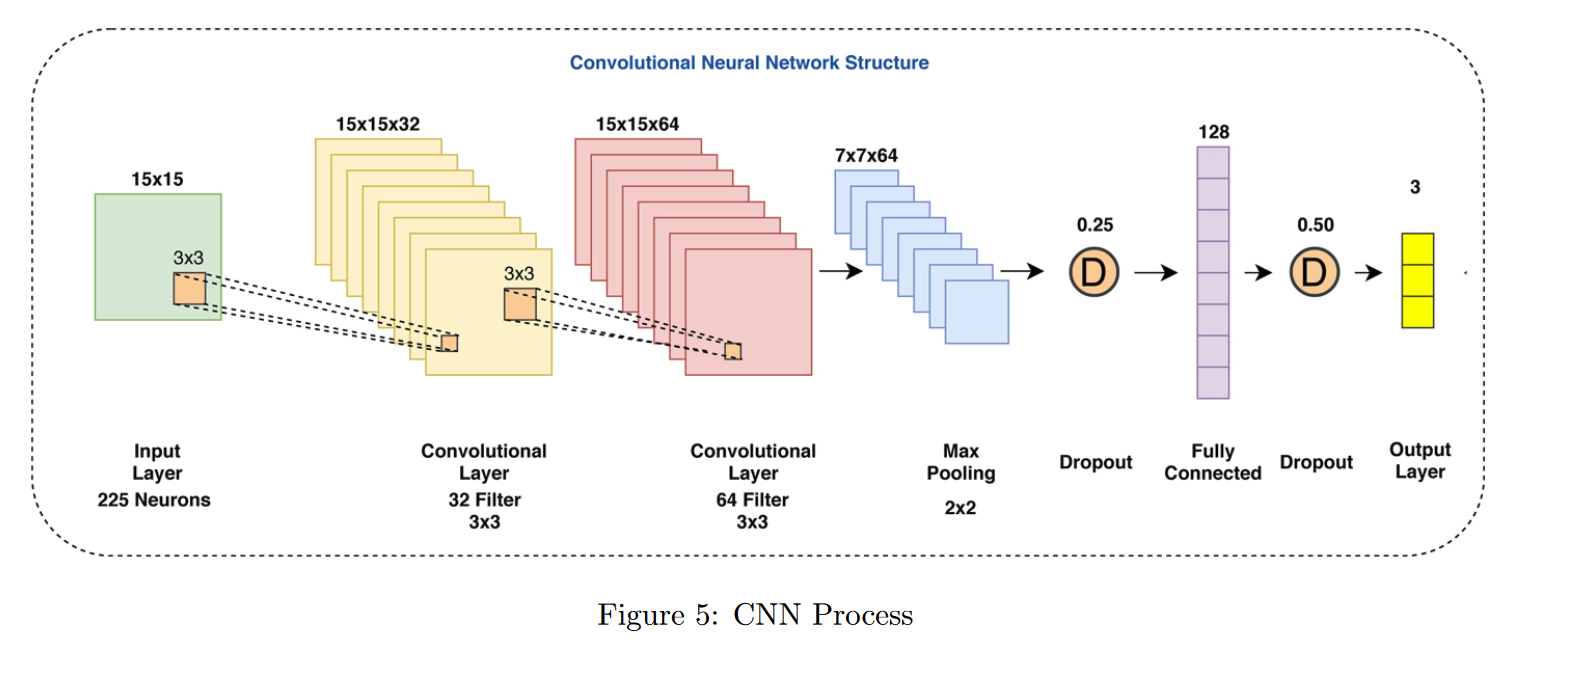


0. 15 x 15
1. 32 @ 15 * 15 (ReLU) (3x3)
2. 64 @ 15 * 15 (ReLU) (3x3)
3. 64 @ 7 * 7 (MaxPooling) (2x2)
4. Dropout 0.25
5. FC 128 (ReLU)
6. Dropout 0.50 
7. Output Layer 10 (Softmax)

### Loss Function

In [60]:
# def f1_loss_approx(predl, actl):
#   act = torch.nn.functional.one_hot(actl)
#   pred = torch.nn.functional.log_softmax(predl)
#   tp = torch.sum(pred*act, dim=0)
#   fp = torch.sum((1-act)*pred, dim=0)
#   fn = torch.sum(act*(1-pred), dim=0)
#   prec = tp/(tp+fp+1e-10)
#   rec = tp / (tp+fn+1e-10)
#   f1 = 2 * prec * rec / (prec + rec+1e-10)
#   f1 = torch.where(torch.isnan(f1), torch.zeros_like(torch.empty(f1.shape[0])), f1)
#   return 1 - torch.mean(f1)

# def modified_ce(pred, act, alpha, gamma=2):
#   c_weight = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(act), y=act.numpy())
#   c_weight = torch.tensor(c_weight, dtype=torch.float)
#   ce_loss = torch.nn.functional.cross_entropy(pred, act, reduction='none', weight=c_weight) # important to add reduction='none' to keep per-batch-item loss
#   pt = torch.exp(-ce_loss)
#   focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean()
#   return focal_loss

### Model 1

In [61]:
class Model1(torch.nn.Module):
  def __init__(self, d1, d2, ll):
    super(Model1, self).__init__()
    # ACT FUNC
    self.relu = torch.nn.ReLU()
    self.sig = torch.nn.Sigmoid()
    self.softmax = torch.nn.Softmax(dim=1)
    # LAYER IN ORDER
    self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1) 
    torch.nn.init.xavier_uniform_(self.conv1.weight, gain=torch.nn.init.calculate_gain('relu'))
    self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
    torch.nn.init.xavier_uniform_(self.conv2.weight, gain=torch.nn.init.calculate_gain('relu'))
    self.maxPool = torch.nn.MaxPool2d(2, stride=2)
    self.dropout1 = torch.nn.Dropout(p=d1)
    torch.manual_seed(10)
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(64*7*7, ll)
    torch.nn.init.xavier_uniform_(self.fc1.weight, gain=torch.nn.init.calculate_gain('relu'))
    self.dropout2 = torch.nn.Dropout(p=d2)
    torch.manual_seed(10)
    self.fc2 = torch.nn.Linear(ll, 3)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
  def forward(self, x):
    # n, 1, 15, 15
    # print(x)
    x = self.relu(self.conv1(x)) # n, 32, 15, 15
    # print(x)
    x = self.relu(self.conv2(x)) # n, 64, 15, 15
    # print(x)
    x = self.maxPool(x) # n, 64, 7, 7
    # print(x)
    x = self.dropout1(x)
    torch.manual_seed(10)
    x = self.flatten(x) # n, 64 * 7 * 7
    x = self.relu(self.fc1(x)) # n, ll
    x = self.dropout2(x)
    torch.manual_seed(10)
    x = self.fc2(x)# n, 3, no softmax because using CEL
    return x


### Train

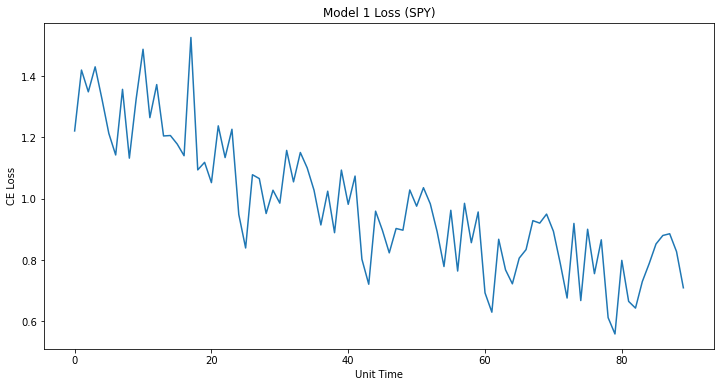

In [62]:
m1= Model1(0.25, 0.5, 64)
xlogger, ylogger = np.array([]), np.array([])
counter = 0
epoch = 5
batch_size = 32
optimizer = torch.optim.SGD(m1.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
for e in range(epoch):
  n_data = in_train.shape[0]
  perm = torch.randperm(n_data)
  for i in range(0, n_data, batch_size):
    optimizer.zero_grad()
    indices = perm[i:i+batch_size]
    batch_x, batch_y = in_train[indices], out_train[indices]
    out = m1.forward(batch_x)
    loss = criterion(out, batch_y)
    loss.backward()
    optimizer.step()
    # Logger
    if ((i//batch_size)+1) % 10 == 0:
      with torch.no_grad():
        xlogger = np.append(xlogger, counter)
        ylogger = np.append(ylogger, loss.item())
        counter += 1    
# PLT SHOW
plt.figure(figsize=(12, 6))
plt.title(f"Model 1 Loss ({STOCKNAME})")
plt.figure(1).patch.set_facecolor("white")
plt.xlabel("Unit Time")
plt.ylabel("CE Loss")
plt.plot(xlogger, ylogger)
plt.show()

### Evaluation Metrics

          HOLD (P)  SELL (P)  BUY (P)
HOLD (A)      1142        58      131
SELL (A)        60         0        5
BUY (A)         60         4        5

Total Accuracy: 0.7829
               HOLD  SELL       BUY
Recall     0.858002   0.0  0.072464
Precision  0.904913   0.0  0.035461
F1 Score   0.880833   0.0  0.047619

Initial Net Worth: $10000, At The End: $15663.87



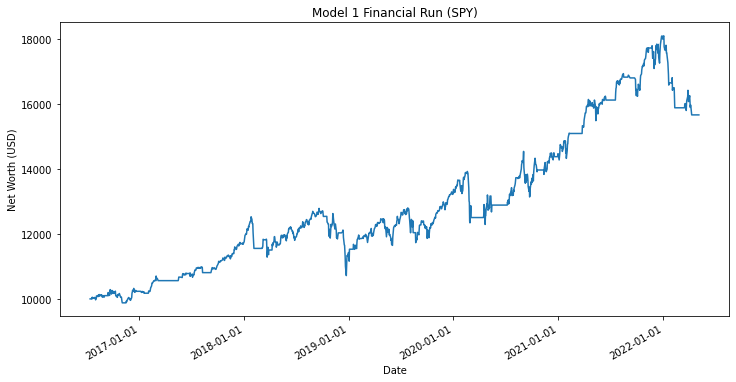

In [63]:
with torch.no_grad():
  classes = ["HOLD", "SELL", "BUY"]
  out = m1.forward(in_test)
  _, outenc = torch.max(out, 1)
  cf_matrix = sklearn.metrics.confusion_matrix(out_test, outenc)
  df_cm = pd.DataFrame(cf_matrix, index = [i+" (A)" for i in classes], columns = [i+" (P)" for i in classes])
  print(df_cm)
  print_eval(cf_matrix, classes)
  do_financial_run(outenc, test_data["Date"], test_data["Close"], 10000, STOCKNAME, "Model 1")

### Model 2

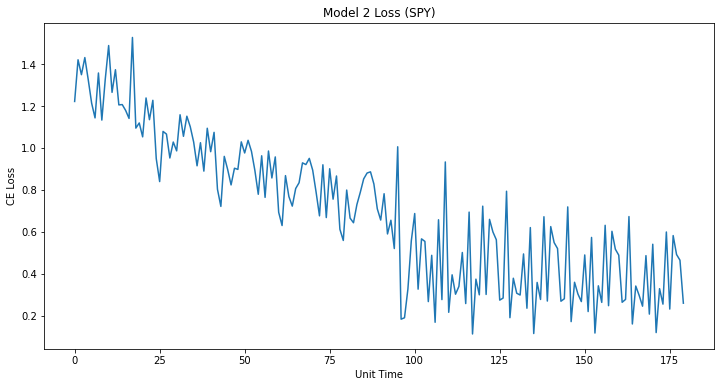

In [64]:
m2 = Model1(0.5, 0.5, 64)
epoch = 5
batch_size = 32
optimizer = torch.optim.RMSprop(m2.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
for e in range(epoch):
  n_data = in_train.shape[0]
  perm = torch.randperm(n_data)
  for i in range(0, n_data, batch_size):
    optimizer.zero_grad()
    indices = perm[i:i+batch_size]
    batch_x, batch_y = in_train[indices], out_train[indices]
    out = m2.forward(batch_x)
    loss = criterion(out, batch_y)
    loss.backward()
    optimizer.step()
    if ((i//batch_size)+1) % 10 == 0:
      with torch.no_grad():
        xlogger = np.append(xlogger, counter)
        ylogger = np.append(ylogger, loss.item())
        counter += 1    
# PLT SHOW
plt.figure(figsize=(12, 6))
plt.title(f"Model 2 Loss ({STOCKNAME})")
plt.xlabel("Unit Time")
plt.ylabel("CE Loss")
plt.figure(1).patch.set_facecolor("white")
plt.plot(xlogger, ylogger)
plt.show()      

#### Evaluation Metrics

          HOLD (P)  SELL (P)  BUY (P)
HOLD (A)      1262        33       36
SELL (A)        64         1        0
BUY (A)         65         0        4

Total Accuracy: 0.8648
               HOLD      SELL       BUY
Recall     0.948159  0.015385  0.057971
Precision  0.907261  0.029412  0.100000
F1 Score   0.927259  0.020202  0.073394

Initial Net Worth: $10000, At The End: $19228.10



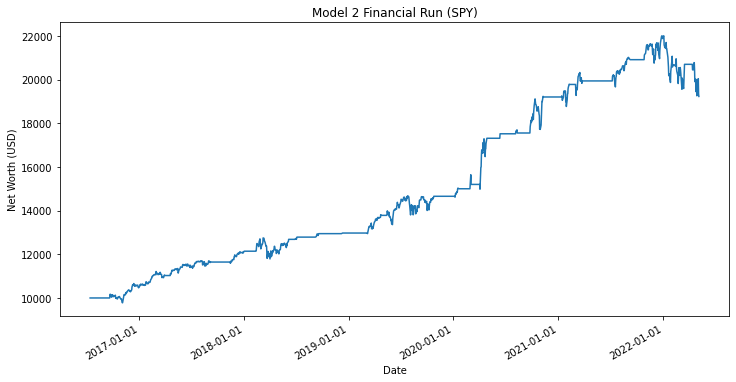

In [65]:
with torch.no_grad():
  classes = ["HOLD", "SELL", "BUY"]
  out = m2.forward(in_test)
  _, outenc = torch.max(out, 1)
  cf_matrix = sklearn.metrics.confusion_matrix(out_test, outenc)
  df_cm = pd.DataFrame(cf_matrix, index = [i+" (A)" for i in classes], columns = [i+" (P)" for i in classes])
  print(df_cm)
  print_eval(cf_matrix, classes)
  do_financial_run(outenc, test_data["Date"], test_data["Close"], 10000, STOCKNAME, "Model 2")

### Model 3

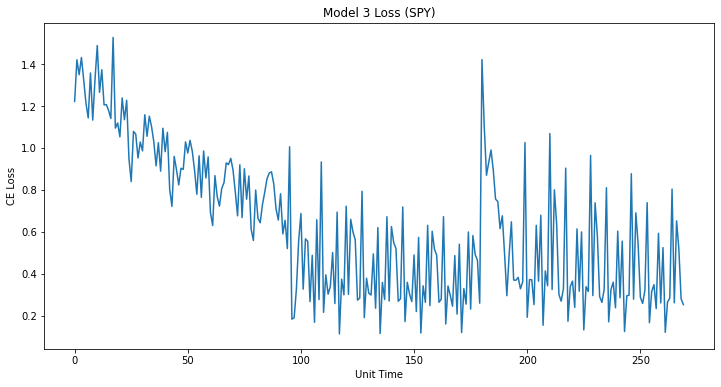

In [66]:
m3 = Model1(0.5, 0.75, 128)
epoch = 5
batch_size = 32
optimizer = torch.optim.NAdam(m3.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
for e in range(epoch):
  n_data = in_train.shape[0]
  perm = torch.randperm(n_data)
  for i in range(0, n_data, batch_size):
    optimizer.zero_grad()
    indices = perm[i:i+batch_size]
    batch_x, batch_y = in_train[indices], out_train[indices]
    out = m3.forward(batch_x)
    loss = criterion(out, batch_y)
    loss.backward()
    optimizer.step()
    if ((i//batch_size)+1) % 10 == 0:
      with torch.no_grad():
        xlogger = np.append(xlogger, counter)
        ylogger = np.append(ylogger, loss.item())
        counter += 1    
# PLT SHOW
plt.figure(figsize=(12, 6))
plt.title(f"Model 3 Loss ({STOCKNAME})")
plt.xlabel("Unit Time")
plt.ylabel("CE Loss")
plt.figure(1).patch.set_facecolor("white")
plt.plot(xlogger, ylogger)
plt.show()         

### Evaluation Metrics

          HOLD (P)  SELL (P)  BUY (P)
HOLD (A)      1076       125      130
SELL (A)        54         7        4
BUY (A)         52         8        9

Total Accuracy: 0.7454
               HOLD      SELL       BUY
Recall     0.808415  0.107692  0.130435
Precision  0.910321  0.050000  0.062937
F1 Score   0.856347  0.068293  0.084906

Initial Net Worth: $10000, At The End: $15963.28



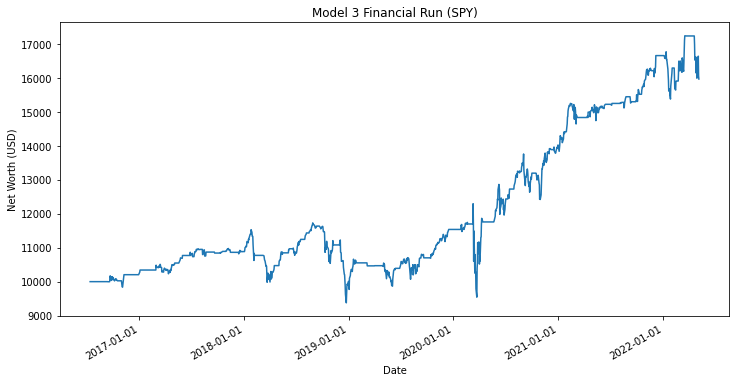

In [67]:
with torch.no_grad():
  classes = ["HOLD", "SELL", "BUY"]
  out = m3.forward(in_test)
  _, outenc = torch.max(out, 1)
  cf_matrix = sklearn.metrics.confusion_matrix(out_test, outenc)
  df_cm = pd.DataFrame(cf_matrix, index = [i+" (A)" for i in classes], columns = [i+" (P)" for i in classes])
  print(df_cm)
  print_eval(cf_matrix, classes)
  do_financial_run(outenc, test_data["Date"], test_data["Close"], 10000, STOCKNAME, "Model 3")